## Imports

In [18]:
# Standard
import json
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Models
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import RandomOverSampler

# Scoring
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from joblib import dump, load


## Data

In [2]:
file_name = 'train_gb'
train = pd.read_pickle(f'..\\processed_data\\{file_name}.pki')

file_name = 'test_gb'
test = pd.read_pickle(f'..\\processed_data\\{file_name}.pki')

In [3]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status,TotalIncome,EMI,BalanceIncome
205,LP001692,0,0,0,1,0,1.0,1,1,4408.0,0.333333,4407.666667
238,LP001790,0,0,1,0,0,1.0,0,1,3812.0,0.311111,3811.688889
25,LP001066,1,1,0,0,1,1.0,1,1,9560.0,0.530556,9559.469444
527,LP002706,1,1,1,1,0,0.0,1,1,6715.0,0.447222,6714.552778
256,LP001849,1,0,0,1,0,0.0,0,0,6045.0,0.319444,6044.680556


In [4]:
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status,TotalIncome,EMI,BalanceIncome
124,LP001439,1,1,0,1,0,1.0,0,1,6314.0,0.538889,6313.461111
414,LP002335,0,1,0,1,0,0.0,1,0,5386.0,0.494444,5385.505556
79,LP001264,1,1,3,1,1,1.0,1,1,5499.0,0.361111,5498.638889
165,LP001574,1,1,0,0,0,1.0,0,1,6873.0,0.505556,6872.494444
295,LP001949,1,1,3,0,0,1.0,2,1,5666.0,0.305556,5665.694444


In [5]:
X = train.drop(['Loan_ID', 'Loan_Status'], axis = 1)
y = train['Loan_Status']
print(X.head())
print(y.head())

     Gender  Married Dependents  Education  Self_Employed  Credit_History  \
205       0        0          0          1              0             1.0   
238       0        0          1          0              0             1.0   
25        1        1          0          0              1             1.0   
527       1        1          1          1              0             0.0   
256       1        0          0          1              0             0.0   

     Property_Area  TotalIncome       EMI  BalanceIncome  
205              1       4408.0  0.333333    4407.666667  
238              0       3812.0  0.311111    3811.688889  
25               1       9560.0  0.530556    9559.469444  
527              1       6715.0  0.447222    6714.552778  
256              0       6045.0  0.319444    6044.680556  
205    1
238    1
25     1
527    1
256    0
Name: Loan_Status, dtype: int32


In [6]:
y.value_counts()

Loan_Status
1    304
0    143
Name: count, dtype: int64

## Hyper-parameter training MLP

In [7]:
# Find the Best Model
param_grid = {
    'hidden_layer_sizes': [200, 300, 400, 500],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [.0001, .001, .01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [200]
}

grid_search = GridSearchCV(MLPClassifier(), param_grid=param_grid, cv=5,scoring='f1_weighted', verbose=5, n_jobs=-1)
grid_search.fit(X, y)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


C:\Users\gs457\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [200, 300, 400, 500],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'max_iter': [200],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             scoring='f1_weighted', verbose=5)

In [17]:
grid_search.best_params_

{'activation': 'logistic',
 'alpha': 0.01,
 'hidden_layer_sizes': 400,
 'learning_rate': 'invscaling',
 'max_iter': 200,
 'solver': 'lbfgs'}

## Bagging

In [9]:
base_model = grid_search.best_estimator_

In [10]:
r = random.randint(1, 101)
model = BaggingClassifier(estimator=base_model, n_estimators=200, bootstrap_features=True, random_state=r, n_jobs=-1)

In [11]:
model.fit(X, y)

BaggingClassifier(bootstrap_features=True,
                  estimator=MLPClassifier(activation='logistic', alpha=0.01,
                                          hidden_layer_sizes=400,
                                          learning_rate='invscaling',
                                          solver='lbfgs'),
                  n_estimators=200, n_jobs=-1, random_state=49)

In [19]:
file_name = 'mlp_model'
dump(model, f'..\\ml_models\\{file_name}.joblib')

['..\\ml_models\\mlp_model.joblib']

## Scoring

In [12]:
X_test, y_test = test.drop(columns=['Loan_ID', 'Loan_Status']), test['Loan_Status']

In [13]:
y_pred = model.predict(X_test)

In [14]:
f1_score(y_pred = y_pred, y_true=y_test)

0.8916666666666667

In [15]:
accuracy_score(y_pred = y_pred, y_true=y_test)

0.8311688311688312

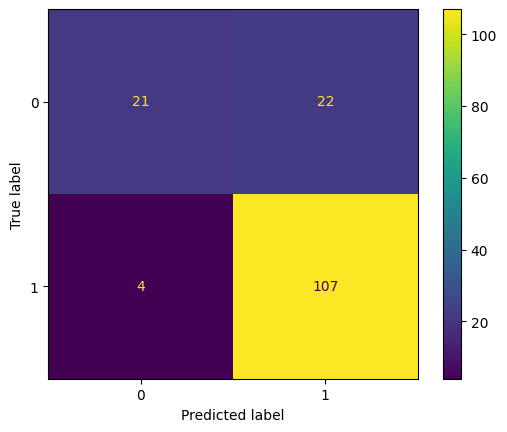

In [16]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_pred = y_pred, y_true=y_test), display_labels=model.classes_)
disp.plot()
plt.show()